### GPT 2 Architecture

In [1]:
# GPT COnfiguration
GPT_CONFIG_124M ={
    "vocab_size":50257,
    "context_length": 1024,
    "num_of_heads":12,
    "num_of_layers":12,
    "emb_dim" : 768,
    "dropout":0.1,
    "qkv_bias":False,
}

In [2]:
import torch
import torch.nn as nn

In [3]:
class DummyGPTModel(nn.Module):

    def __init__(self,cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["dropout"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformer(cfg) for _ in range(cfg["num_of_layers"])
        ])
        self.final_norm = LayerNormBlock(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"] , cfg["vocab_size"],
            bias = False
        )


    def forward(self,in_idx):
        batch_size, seq_len = in_idx.shape

        tok_embs = self.token_emb(in_idx)
        pos_embs = self.pos_emb(torch.arange(seq_len, device = in_idx.device))

        final_embs = tok_embs + pos_embs
        x = self.drop_emb(final_embs)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformer(nn.Module):

    def __init__(self,cfg):
        super().__init__()
        # simple Placeholder
    
    def forward(self ,x):
        return x


class LayerNormBlock(nn.Module):

    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))      
        # simple Placeholder

    
    def forward(self,x):
        mean = x.mean(dim = -1, keepdim =True)
        var = x.var(dim = -1, keepdim =True, unbiased = False)

        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [17]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,x):
        return 0.5* x *(1+ torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
                    (x + 0.044715 * torch.pow(x ,3))
        ))

In [18]:
import matplotlib.pyplot as plt

x = torch.linspace(-3, 3,100)

gelu , relu = GELU(), nn.ReLU()

y_gelu ,y_relu = gelu(x) ,relu(x)


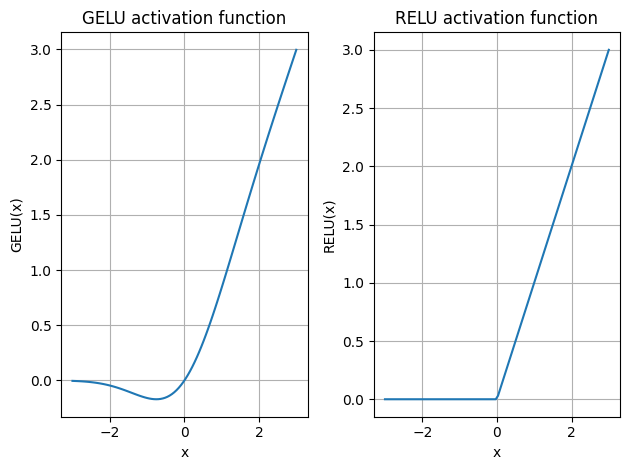

In [22]:
plt.Figure(figsize=(8,3))
for i, (y,label) in enumerate(zip([y_gelu ,y_relu],["GELU","RELU"]),1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"] , 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"] ,cfg["emb_dim"])
        )
    
    def forward(self,x):
        return self.layers(x)

In [24]:
x = torch.rand(2,3,768)
ffn = FeedForward(GPT_CONFIG_124M)
out = ffn(x)

print(out.shape)

torch.Size([2, 3, 768])


In [4]:
import tiktoken as tk

tokenizer = tk.get_encoding("gpt2")
batch = []
txt1 ="your every effort moves"
txt2 = "your day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch= torch.stack(batch, dim=0)

# print shape of batch
print(batch.shape) # (2, 20)

torch.Size([2, 4])


In [5]:
torch.manual_seed(123)

model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)

In [6]:
print("Shape is:" , logits.shape)
print("logits is \n", logits)

Shape is: torch.Size([2, 4, 50257])
logits is 
 tensor([[[-0.3208, -0.6066,  0.1479,  ..., -0.2295,  0.1462,  0.2813],
         [-0.5327, -0.1306, -0.7919,  ..., -0.7295,  0.4653,  0.8584],
         [ 0.4892,  0.4506,  0.2277,  ..., -0.0511,  1.1156, -0.1335],
         [ 0.2048,  0.7581, -0.3817,  ...,  1.9693, -0.2384,  0.8500]],

        [[-0.5489, -0.8214,  0.1567,  ..., -0.0234,  0.4626,  0.2666],
         [-0.5938,  0.4453, -0.0059,  ...,  0.3414,  0.0572,  1.0986],
         [ 0.2675,  0.8407, -0.4476,  ..., -0.0181, -0.1090,  0.2541],
         [-0.1035, -0.5901, -0.3932,  ...,  1.4022, -0.3188,  0.1304]]],
       grad_fn=<UnsafeViewBackward0>)


### Layer Normalization


In [7]:
import torch
import torch.nn as nn
torch.manual_seed(123)

batch_example = torch.randn(2,5)

layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())

out = layer(batch_example)

print(out.shape) # (2, 6)
print(out)

torch.Size([2, 6])
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
mean = out.mean(dim = -1, keepdim = True)
var = out.var(dim = -1,keepdim = True)

In [9]:
print(mean)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)


In [10]:
print(var)

tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [11]:
out_norm = (out - mean) / torch.sqrt(var)

print("Mormalizer Output Layer : \n", out_norm)
print("Mean: \ n", out_norm.mean(dim = -1, keepdim = True))
print("var: \ n", out_norm.var(dim = -1, keepdim = True))

Mormalizer Output Layer : 
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean: \ n tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
var: \ n tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [12]:
torch.set_printoptions(sci_mode = False)
print("Mean: \ n", out_norm.mean(dim = -1, keepdim = True))
print("var: \ n", out_norm.var(dim = -1, keepdim = True))

Mean: \ n tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
var: \ n tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [13]:
ln = LayerNormBlock(emb_dim = 5)

ln(batch_example)

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)

In [36]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_in :int,d_out:int,num_of_heads:int,
                 context_length:int,dropout:float,qkv_bias:bool=False):
        super().__init__()
        self.d_out = d_out
        assert (d_out % num_of_heads == 0),\
              "d_out is not divisible by num_of_heads"
        self.head_dim = d_out // num_of_heads
        self.num_of_heads = num_of_heads
        self.w_query = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_Key = nn.Linear(d_in,d_out,bias=qkv_bias) 
        self.w_value = nn.Linear(d_in,d_out,bias=qkv_bias) 
        self.projLayer = nn.Linear(d_out,d_out,bias=qkv_bias) 
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length,context_length),
                       diagonal=1)
        )   


    def forward(self,x):
        b, num_of_token , d_in = x.shape
        
        Query = self.w_query(x) 
        Key = self.w_Key(x) 
        Value = self.w_value(x) 

        #(b,num_of_token,d_in) ---> (b,num_of_token,num_of_heads,head_dim) 
        Query = Query.view(b,num_of_token,self.num_of_heads,self.head_dim)
        Key = Key.view(b,num_of_token,self.num_of_heads,self.head_dim)
        Value = Value.view(b,num_of_token,self.num_of_heads,self.head_dim)

        # Grouping By heads ( transpose 1 and 2 shape)
        #shape : (b,num_of_heads,num_of_token,head_dim) 
        Query = Query.transpose(1,2)
        Key = Key.transpose(1,2)
        Value = Value.transpose(1,2)

        # attaention score
        atten_score  = Query @ Key.transpose(2,3)

        # create mask
        mask_bool  = self.mask.bool()[:num_of_token,:num_of_token]

        #apply mask
        atten_score = atten_score.masked_fill(
                            mask_bool,
                            -torch.inf
                        )

        # apply softmax
        attn_weight = torch.softmax(
            atten_score / Key.shape[-1] ** 0.5 , dim = -1
        )

        #context vector
        context_vec  = (attn_weight @ Value).transpose(1,2)

        #Merge Head_dim (b,num_of_token,num_of_heads,head_dim) --> (b,num_of_token,d_out)
        context_vec = context_vec.contiguous().view(b,num_of_token,self.d_out)

        # apply projection layer
        context_vec = self.projLayer(context_vec)
        
        # apply dropout and return
        return self.dropout(context_vec)



In [37]:
batch_size = 2
num_tokens = 5
d_in = 16
d_out = 16
num_heads = 4
context_length = 10
dropout = 0.1

In [38]:
mha = MultiHeadAttention(d_in= d_in, d_out=d_out, num_of_heads=num_heads,context_length=context_length,
                         dropout=dropout)

In [39]:
x = torch.randn(batch_size, num_tokens, d_in)